In [1]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_portal.csv')
#df = df[df['round'] == 'First Round']
print(df.shape)
df.head()

(251, 87)


,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,win,wab,prpg!,...,D_B,D_C,D_D,D_F,F_S,F_A,F_B,F_C,F_D,F_F
0,2021,West,First Round,1,2021 Gonzaga,16,2021 Norfolk St.,1,13.5317,12.7000,...,0,0,0,0,0,0,0,0,0,0
1,2021,West,Second Round,1,2021 Gonzaga,8,2021 Oklahoma,1,8.2153,8.7000,...,0,0,0,0,0,0,0,0,0,0
2,2021,West,Sweet 16,1,2021 Gonzaga,5,2021 Creighton,1,5.2488,5.6000,...,0,0,0,0,0,0,0,0,0,0
3,2021,West,Elite Eight,1,2021 Gonzaga,6,2021 USC,1,2.9567,4.5000,...,0,0,0,0,0,0,0,0,0,0
4,2021,Final Four,Final Four,1,2021 Gonzaga,11,2021 UCLA,1,5.8598,6.8000,...,0,0,0,0,0,0,0,0,0,0


In [2]:
df['win'].value_counts(normalize=True)

1   0.6056
0   0.3944
Name: win, dtype: float64

In [3]:
df.columns

Index(['year', 'region', 'round', 'high_bracket_seed', 'high_bracket_team',
       'low_bracket_seed', 'low_bracket_team', 'win', 'wab', 'prpg!', 'dprpg',
       'bpm', 'obpm', 'dbpm', 'bpr', 'obpr', 'dbpr', 'kenpom_adjem',
       'kenpom_adjoe', 'kenpom_adjde', 'barthag', 'barthag_oe', 'barthag_de',
       'off_eff', 'def_eff', 'efg%', 'ftr', 'tor', 'orb%', 'efgd%', 'ftrd',
       'tord', 'drb%', '2p%', '3p%', 'blked%', 'ast%', '3pr', 'ft%', '2p%d',
       '3p%d', 'blk%', 'ast%d', '3prd', 'ft%d', 'height', 'size', 'experience',
       'bench', 'high_tier', 'low_tier', 'S_S', 'S_A', 'S_B', 'S_C', 'S_D',
       'S_F', 'A_S', 'A_A', 'A_B', 'A_C', 'A_D', 'A_F', 'B_S', 'B_A', 'B_B',
       'B_C', 'B_D', 'B_F', 'C_S', 'C_A', 'C_B', 'C_C', 'C_D', 'C_F', 'D_S',
       'D_A', 'D_B', 'D_C', 'D_D', 'D_F', 'F_S', 'F_A', 'F_B', 'F_C', 'F_D',
       'F_F'],
      dtype='object')

In [4]:
eda_df = df[[
    'win', 
    'wab', 
    'prpg!', 
    'dprpg',
    'bpm', 
    'obpm', 
    'dbpm', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'kenpom_adjde', 
    'barthag', 
    'barthag_oe', 
    'barthag_de',
    'off_eff', 
    'def_eff', 
    'efg%',
    'ftr', 
    'tor', 
    'orb%', 
    'efgd%', 
    'ftrd',
    'tord', 
    'drb%', 
    '2p%', 
    '3p%', 
    'blked%', 
    'ast%', 
    '3pr', 
    'ft%', 
    '2p%d',
    '3p%d', 
    'blk%', 
    'ast%d', 
    '3prd', 
    'ft%d', 
    'height', 
    'size', 
    'experience',
    'bench']]

In [7]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(200, 39)
(51, 39)


# I. Numerical Tests

In [8]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 20]
print(correlation_with_target)

wab             37.1400
prpg!           34.7500
dprpg           36.6000
bpm             41.5600
obpm            37.1600
dbpm            34.4000
kenpom_adjem    37.5400
kenpom_adjoe    30.5800
kenpom_adjde    25.6800
barthag         35.7300
barthag_oe      32.2900
barthag_de      28.9400
off_eff         21.6500
efg%            20.0100
win            100.0000
Name: win, dtype: float64


In [9]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,wab,31.6736,0.0000,0.1491
1,prpg!,27.1963,0.0000,0.0539
2,dprpg,30.6333,0.0000,0.1194
3,bpm,41.3387,0.0000,0.1262
4,obpm,31.7288,0.0000,0.0344
5,dbpm,26.5678,0.0000,0.0987
6,kenpom_adjem,32.4803,0.0000,0.0397
7,kenpom_adjoe,20.4313,0.0000,0.0423
8,kenpom_adjde,13.9814,0.0002,0.0251
9,barthag,28.9747,0.0000,0.1013


In [10]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
0,wab,31.6736,0.0000,0.1491
1,prpg!,27.1963,0.0000,0.0539
2,dprpg,30.6333,0.0000,0.1194
3,bpm,41.3387,0.0000,0.1262
5,dbpm,26.5678,0.0000,0.0987
9,barthag,28.9747,0.0000,0.1013
11,barthag_de,18.0986,0.0000,0.0763
13,def_eff,5.5000,0.0200,0.0637
17,orb%,3.1022,0.0797,0.0733
24,blked%,4.2227,0.0412,0.0505


In [11]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
0,wab,31.6736,0.0000,0.1491
1,prpg!,27.1963,0.0000,0.0539
2,dprpg,30.6333,0.0000,0.1194
3,bpm,41.3387,0.0000,0.1262
4,obpm,31.7288,0.0000,0.0344
5,dbpm,26.5678,0.0000,0.0987
6,kenpom_adjem,32.4803,0.0000,0.0397
7,kenpom_adjoe,20.4313,0.0000,0.0423
8,kenpom_adjde,13.9814,0.0002,0.0251
9,barthag,28.9747,0.0000,0.1013


In [12]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
0,wab,31.6736,0.0000,0.1491
1,prpg!,27.1963,0.0000,0.0539
2,dprpg,30.6333,0.0000,0.1194
3,bpm,41.3387,0.0000,0.1262
4,obpm,31.7288,0.0000,0.0344
5,dbpm,26.5678,0.0000,0.0987
6,kenpom_adjem,32.4803,0.0000,0.0397
7,kenpom_adjoe,20.4313,0.0000,0.0423
8,kenpom_adjde,13.9814,0.0002,0.0251
9,barthag,28.9747,0.0000,0.1013


# II. Wrapper Methods

In [13]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [14]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [15]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 38
selected features: 17
features with coefficients shrank to zero: 21


In [16]:
selected_feat

Index(['dprpg', 'bpm', 'obpm', 'barthag_de', 'def_eff', 'ftrd', '2p%', '3p%',
       'blked%', 'ast%', '3pr', 'ft%', '2p%d', 'blk%', 'ast%d', 'height',
       'bench'],
      dtype='object')

In [17]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.80
Lasso Regression F1 Score (Test): 0.70


In [18]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [19]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [20]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['wab', 'bpm', 'kenpom_adjde', 'barthag_de', 'def_eff', 'ftr',
       'orb%', 'tord', 'ast%d', 'bench'], dtype=object)

In [21]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9144736842105263
Test set
Random Forests roc-auc: 0.6071428571428572


In [22]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9178692699490661
Test set
Random Forests roc-auc: 0.6925465838509317


In [23]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5388198757763976,
 0.5885093167701864,
 0.592391304347826,
 0.5760869565217391,
 0.5194099378881987,
 0.5527950310559007,
 0.47748447204968947,
 0.5225155279503105,
 0.5822981366459627,
 0.44177018633540366,
 0.499223602484472,
 0.5885093167701863,
 0.5093167701863355,
 0.45186335403726713,
 0.5496894409937887,
 0.5543478260869565,
 0.5287267080745341,
 0.5263975155279503,
 0.5062111801242236,
 0.32919254658385094,
 0.4503105590062112,
 0.4860248447204969,
 0.639751552795031,
 0.3408385093167702,
 0.5450310559006211,
 0.5380434782608696,
 0.453416149068323,
 0.47903726708074534,
 0.6172360248447206,
 0.4270186335403726,
 0.5271739130434783,
 0.42934782608695654,
 0.4347826086956522,
 0.36723602484472045,
 0.452639751552795,
 0.4324534161490683,
 0.468944099378882,
 0.5380434782608696]

Text(0, 0.5, 'roc-auc')

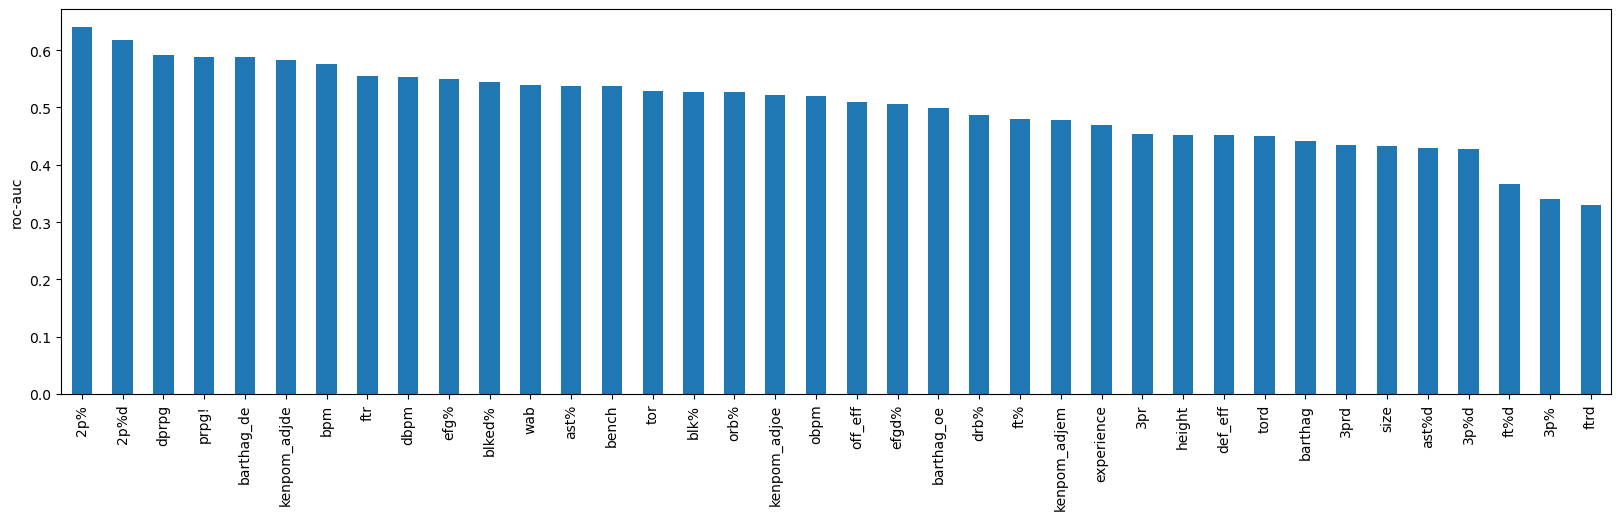

In [24]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [25]:
len(roc_values[roc_values > 0.6])

2

In [26]:
roc_values[roc_values > 0.6]

2p%    0.6398
2p%d   0.6172
dtype: float64

In [27]:
roc_values[roc_values > 0.55]

prpg!          0.5885
dprpg          0.5924
bpm            0.5761
dbpm           0.5528
kenpom_adjde   0.5823
barthag_de     0.5885
ftr            0.5543
2p%            0.6398
2p%d           0.6172
dtype: float64

# III. XGBoost

In [28]:
X_train_scaled2 = X_train_scaled[[
'prpg!',
'dprpg',
'bpm',
'dbpm',
'kenpom_adjde',
'barthag_de',
'ftr',
'2p%',
'2p%d'
]]

X_test_scaled2 = X_test_scaled[[
'prpg!',
'dprpg',
'bpm',
'dbpm',
'kenpom_adjde',
'barthag_de',
'ftr',
'2p%',
'2p%d'
]]

In [29]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.4, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.3}


In [30]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [31]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.6344199095336419


In [32]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.85
F1 Score on Test Data: 0.75


<Figure size 1000x600 with 0 Axes>

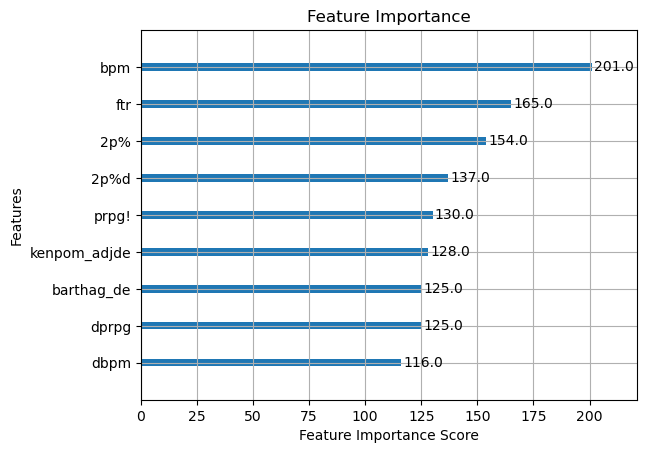

In [33]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()